In [1]:
from preprocess.arpit_v2 import *
from preprocess.preprocess_v2 import *
from preprocess.preprocess_v2 import preprocess
import os
import inspect
import time
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
from models.LDA_multi_level import lda_model_multi_level
from models.LDA_single_level import lda_model_single_level
from models.lda_mallet import lda_mallet
%matplotlib inline
from newsplease import NewsPlease
print('------------------------------------------------------')
print('- Imports Done')

------------------------------------------------------
- Imports Done


## LDA on gold_standard.csv - Text 

### Extracting text

In [2]:
# One way to get articles corresponding to gold-standards are

def load_obj(month, idx):
    month = str(month).zfill(2)
    idx = str(idx).zfill(5)
    with open("data/texts/{}/{}.pkl".format(month, idx), "rb") as f:
        return pickle.load(f)
    
def load_dict(month):
    month = str(month).zfill(2)
    with open("data/metadata/matching/{}.pkl".format(month), "rb") as f:
        return pickle.load(f)
    
gs = pd.read_csv('data/gold-standard/gold_standard.csv')

gs_articles = {}

for i in range(len(gs)):
    article = load_obj(gs['month'][i], gs['ids'][i])
    gs_articles[i] = article

In [3]:
print('Total articles: ' ,len(gs_articles))

Total articles:  208


In [4]:
gs_text = []
for key, value in gs_articles.items():
    gs_text.append(value.text)
gs_text = np.array(gs_text)

In [5]:
raw_docs = gs_text

In [11]:
print('Total documents - ', len(raw_docs))
type(raw_docs)


Total documents -  208


numpy.ndarray

In [12]:
# DATA
# Note that raw docs is a numpy array. 
# Example element is: 
# 'Logical Disk Free Space is low, Description: The disk C: on computer sjcphxstg02.strykercorp.com is running out of disk space. The values that exceeded the thre'
# data_file_string = 'short_description.pkl'

# data_file_string = 'gold_standard.csv'
# data_file = os.path.join(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))),'data',data_file_string)
# raw_docs = pickle.load(open(data_file,'rb'))

print('- Imported Data')

- Imported Data


In [13]:
# PRE-PROCESSING
preprocess_steps_and_order = {
	'make_lowercase': [True],
	'punctuation_removal':[True],
	'whitespace_removal': [True],
	'store_alphanumeric': [False],
	'pos_removal_nltk': [True, {'pos_removal_nltk_list':['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  'PRP','PRP$',  'RB','RBR','RBS','RP',  'JJ','JJR','JJS',   'CC','DT','EX','IN',   'WDT','WP','WP$','WRB']}],
	'tokenization_nltk': [False],
	'lemmatization_tokenization_spacy': [True],
	'stopwords_removal_nltk': [True],
	'stopwords_removal_spacy': [False],
	'make_bigrams_gensim':[True, {'make_bigrams_gensim': True, 'bigrams_min_count': 10, 'bigrams_threshold': 10}],
	'make_trigrams_gensim':[True, {'make_trigrams_gensim': True, 'trigrams_min_count': 10, 'trigrams_threshold': 10}],
	'min_max_length_removal':[False, {'min_max_length_removal': False, 'mmlr_min_len': 3, 'mmlr_max_len': 50, 'mmlr_deacc': False}]
	}

preprocess_functions = {
	'make_lowercase': make_lowercase,
	'punctuation_removal': punctuation_removal,
	'whitespace_removal': whitespace_removal,
	'store_alphanumeric': store_alphanumeric,
	'pos_removal_nltk': pos_removal_nltk,
	'tokenization_nltk': tokenization_nltk,
	'lemmatization_tokenization_spacy': lemmatization_tokenization_spacy,
	'stopwords_removal_nltk': stopwords_removal_nltk,
	'stopwords_removal_spacy': stopwords_removal_spacy,
	'make_bigrams_gensim': make_bigrams_gensim,
	'make_trigrams_gensim': make_trigrams_gensim,
	'min_max_length_removal': min_max_length_removal
	}

In [14]:
# MODELS
models_dict = {
	'LDA_single_level': lda_model_single_level,
	'LDA_multi_level': lda_model_multi_level,
}

In [15]:
# SPECIFICATIONS

num_topics_list_level_1 = np.arange(1,51,1).tolist()
# num_topics_list_level_1 = [6]

specifications = {
	# 'model':'LDA_single_level', # Can be LDA_multi_level
	'level':2,
	'num_topics_list_level_1':num_topics_list_level_1,
	'num_topics_list_level_2':[3,5,8,11],
	'num_topics_list_level_3':[1,2,3,4,5],
	'coherence':'c_v',
	'need_best_topic': True,
	'model_selection_metric':'coherence', # or 'perplexity',
	'debug':False,
    'sample_to_print':1,
#     'pos_removal_spacy_list':['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE'],
}

In [16]:
print('*****************************************************')
print('- Starting preprocessing')
dictionary, corpus, doc_list = preprocess(
								raw_docs = raw_docs, 
								preprocess_functions = preprocess_functions, 
								preprocess_steps_and_order = preprocess_steps_and_order, 
								debug=specifications['debug'])

*****************************************************
- Starting preprocessing

       ##### Lowercasing Done! Time Taken -  0.002924203872680664

       ##### Punctuation removed! Time Taken -  0.0332338809967041

       ##### Whitespace removed! Time Taken -  0.010531187057495117

       ##### POS Removal Done! Time Taken -  3.524953842163086

       ##### Lemmatization and Tokenization Done using Spacy! Time Taken -  5.1471171379089355

       ##### Stopwords Removed using NLTK! Time Taken -  0.025380849838256836

       ##### Bi-Grams made using Gensim! Time Taken -  0.1343679428100586

       ##### Tri-Grams made using Gensim! Time Taken -  0.14071083068847656
~~~ pre-processing done in  9.022434711456299
 
- Creating dictionary and corpus


### LDA Single Level

In [17]:
print('*****************************************************')
print('- Starting model training')
lda_dict = lda_model_single_level(
					dictionary = dictionary,
					corpus = corpus,
					doc_list = doc_list,
					num_topics_list_level_1 = specifications['num_topics_list_level_1'], 
					coherence = specifications['coherence'],
					debug = specifications['debug'],
					need_best_topic = specifications['need_best_topic'],
					model_selection_metric = specifications['model_selection_metric']
					)

*****************************************************
- Starting model training
 
Sample data point:  ['shelter', 'woman', 'inspection', 'june', 'manager', 'arti', 'agarwal', 'yesterday', 'name', 'shelter', 'donation', 'administration']
 
	### Running LDA for number of topic - 1
	LDA Done for 1 topic! Time Taken is 0.22441792488098145
	Evaluating model for number of topic - 1
Coherence - 0.4166462634345101, Perplexity - -8.13617825026873
---
	### Running LDA for number of topic - 2
	LDA Done for 2 topic! Time Taken is 0.7948160171508789
	Evaluating model for number of topic - 2
Coherence - 0.4126997673735422, Perplexity - -8.107569199857098
---
	### Running LDA for number of topic - 3
	LDA Done for 3 topic! Time Taken is 0.8413822650909424
	Evaluating model for number of topic - 3
Coherence - 0.4873029536010027, Perplexity - -8.098656103203986
---
	### Running LDA for number of topic - 4
	LDA Done for 4 topic! Time Taken is 0.9281570911407471
	Evaluating model for number of topic - 4
C

	LDA Done for 39 topic! Time Taken is 1.7007408142089844
	Evaluating model for number of topic - 39
Coherence - 0.42239335744742296, Perplexity - -13.749533368459042
---
	### Running LDA for number of topic - 40
	LDA Done for 40 topic! Time Taken is 1.6043682098388672
	Evaluating model for number of topic - 40
Coherence - 0.4420002140530297, Perplexity - -14.00804214358015
---
	### Running LDA for number of topic - 41
	LDA Done for 41 topic! Time Taken is 1.512876033782959
	Evaluating model for number of topic - 41
Coherence - 0.42465484019675004, Perplexity - -14.047959723982625
---
	### Running LDA for number of topic - 42
	LDA Done for 42 topic! Time Taken is 1.6604657173156738
	Evaluating model for number of topic - 42
Coherence - 0.4319199056805577, Perplexity - -14.233216652216225
---
	### Running LDA for number of topic - 43
	LDA Done for 43 topic! Time Taken is 1.617278814315796
	Evaluating model for number of topic - 43
Coherence - 0.4359375592595198, Perplexity - -14.34118065

In [18]:
print('Best Topic',lda_dict['best_topic'])

Best Topic 3


<Figure size 864x864 with 0 Axes>

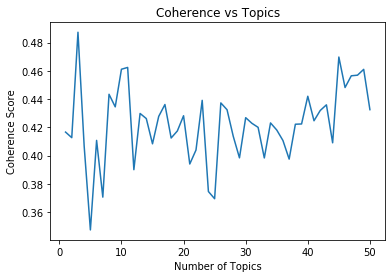

<Figure size 864x864 with 0 Axes>

In [19]:
plt.plot(num_topics_list_level_1, lda_dict['coherence_score_list'])
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence vs Topics')
plt.figure(figsize=(12,12))

In [21]:
lda_dict['coherence_score_list']

array([0.41664626, 0.41269977, 0.48730295, 0.40661066, 0.34740744,
       0.41076694, 0.37061191, 0.44340057, 0.43449378, 0.46112388,
       0.46239724, 0.39003308, 0.42982932, 0.42621117, 0.40834544,
       0.42775672, 0.43615733, 0.41245559, 0.41743477, 0.42820783,
       0.39405494, 0.40393214, 0.4391042 , 0.37457689, 0.3694879 ,
       0.43729134, 0.43246657, 0.4136561 , 0.3984153 , 0.42684566,
       0.4228648 , 0.41999407, 0.39833855, 0.42312545, 0.41811954,
       0.41068501, 0.39751908, 0.42219973, 0.42239336, 0.44200021,
       0.42465484, 0.43191991, 0.43593756, 0.40904729, 0.46975678,
       0.44818749, 0.45648046, 0.45690998, 0.46103261, 0.43250922])

<Figure size 864x864 with 0 Axes>

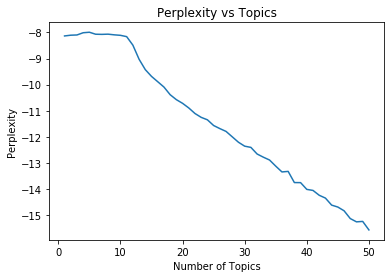

<Figure size 864x864 with 0 Axes>

In [20]:
plt.plot(num_topics_list_level_1, lda_dict['perplexity_score_list'])
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Topics')
plt.figure(figsize=(12,12))

In [22]:
pyLDAvis.enable_notebook()
topic_to_show = 11
visualization = pyLDAvis.gensim.prepare(lda_dict['all_models'][topic_to_show], lda_dict['corpus'], lda_dict['dictionary'])
# pyLDAvis.save_html(visualization, 'lda_10.html')
visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.079570 -0.076701       1        1  21.450985
1      0.000697 -0.067869       2        1  20.795015
10     0.066186 -0.015708       3        1  15.459535
6      0.075338 -0.044705       4        1  10.674651
8      0.002586  0.333527       5        1   9.370770
9      0.070500 -0.033714       6        1   7.379885
4     -0.357268 -0.010700       7        1   6.441206
2      0.031155 -0.043802       8        1   4.578678
3      0.059375 -0.011034       9        1   1.695938
7      0.070093 -0.016606      10        1   1.143618
0      0.060908 -0.012688      11        1   1.009724, topic_info=     Category        Freq                       Term       Total  loglift  \
3508  Default   80.000000                       pump   80.000000  30.0000   
674   Default  131.000000                acquisition  131.000000  29.0000   
210   Default   43.000000                        cow   43.000000  28.0000   
2160  Default   73.000000                       coal   73.000000  27.0000   
1350  Default   55.000000                       mine   55.000000  26.0000   
...       ...         ...                        ...         ...      ...   
170   Topic11    0.855163                    farming    5.505430   2.7333   
192   Topic11    0.709145                    product    6.919057   2.3175   
228   Topic11    0.635544  story_business_staff_auto    6.692195   2.2413   
211   Topic11    0.655829                       feed    7.589556   2.1469   
85    Topic11    0.591787                     sector   23.043234   0.9335   

      logprob  
3508  30.0000  
674   29.0000  
210   28.0000  
2160  27.0000  
1350  26.0000  
...       ...  
170   -5.5229  
192   -5.7101  
228   -5.8197  
211   -5.7883  
85    -5.8911  

[542 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3488      1  0.196432     accident
3488      7  0.785727     accident
2452      1  0.979828      account
674       1  0.993958  acquisition
11        1  0.852225         acre
...     ...       ...          ...
434       6  0.067136       worker
434       7  0.570654       worker
1827      9  0.890421        wound
4622      4  0.901615  yeddyurappa
971       3  0.943651            …

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 11, 7, 9, 10, 5, 3, 4, 8, 1])

In [23]:
def get_topics(lda_model):
	topics = lda_model.print_topics()
	print("~~~ Topics are:")
	for i in range(len(topics)):
		print('Topic ',i)
		print(topics[i][1])
		print(' ')

In [24]:
get_topics(lda_dict['all_models'][topic_to_show])

~~~ Topics are:
Topic  0
0.015*"chemical" + 0.012*"gas" + 0.010*"productivity" + 0.006*"goa" + 0.005*"anniversary" + 0.005*"carbide" + 0.005*"epa" + 0.005*"file" + 0.004*"farming" + 0.004*"sanjeev"
 
Topic  1
0.018*"owner" + 0.010*"question" + 0.008*"dam" + 0.008*"generation" + 0.008*"document" + 0.007*"river" + 0.007*"loss" + 0.006*"september" + 0.006*"rs" + 0.005*"protester"
 
Topic  2
0.016*"manager" + 0.016*"ghat" + 0.013*"establishment" + 0.013*"inspection" + 0.013*"delhi_border" + 0.013*"trailer" + 0.013*"arrival" + 0.012*"force" + 0.012*"tikait" + 0.010*"bku"
 
Topic  3
0.094*"cow" + 0.037*"stone" + 0.032*"slaughter" + 0.030*"police_officer" + 0.029*"pit" + 0.028*"police_station" + 0.026*"wound" + 0.026*"vehicle" + 0.026*"crowd" + 0.016*"cattle"
 
Topic  4
0.058*"pump" + 0.038*"mine" + 0.031*"rescue_operation" + 0.021*"site" + 0.020*"diver" + 0.020*"miner" + 0.019*"coal_mine" + 0.018*"rat_hole" + 0.016*"foot" + 0.015*"accident"
 
Topic  5
0.029*"acquisition" + 0.016*"authority" 

### LDA Multi-Level

In [20]:
# print('*****************************************************')
# print('- Starting model training')
# lda_level_1, lda_level_2 = lda_model_multi_level(
# 					level = specifications['level'],
# 					dictionary = dictionary,
# 					corpus = corpus,
# 					doc_list = doc_list,
# 					coherence = specifications['coherence'],
# 					debug = specifications['debug'],
# 					need_best_topic = specifications['need_best_topic'],
# 					model_selection_metric = specifications['model_selection_metric'],
# 					num_topics_list_level_1 = specifications['num_topics_list_level_1'], 
# 					num_topics_list_level_2 = specifications['num_topics_list_level_2'], 
# 					)

### Mallet LDA

In [21]:
# print('*****************************************************')
# print('- Starting model training')
# lda_dict = lda_mallet(
# 					dictionary = dictionary,
# 					corpus = corpus,
# 					doc_list = doc_list,
# 					num_topics_list_level_1 = specifications['num_topics_list_level_1'], 
# 					coherence = specifications['coherence'],
# 					debug = specifications['debug'],
# 					need_best_topic = specifications['need_best_topic'],
# 					model_selection_metric = specifications['model_selection_metric']
# 					)

## Visualization

In [91]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### What is the Dominant topic and its percentage contribution in each document

In [ ]:
# In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. 
# The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a 
# nicely formatted output.
# This way, you will know which document belongs predominantly to which topic.

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_dict['all_models'][topic_to_show], corpus=corpus, texts=doc_list)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8333,"manager, ghat, establishment, inspection, delh...","[shelter, woman, inspection, june, manager, ar..."
1,1,6.0,0.5656,"debt, congress, karnataka, election, modi, pro...","[rain, kerala, region, karnataka, trail, destr..."
2,2,9.0,0.9526,"experience, message, change, spirit, crore, su...","[assassination, convict, rajiv, gandhi, tamil_..."
3,3,0.0,0.4773,"chemical, gas, productivity, goa, anniversary,...","[state, government, farm, policy, farmer, pric..."
4,4,6.0,0.7217,"debt, congress, karnataka, election, modi, pro...","[person, police, cow, abattoir, area, madhya, ..."
5,5,4.0,0.5676,"pump, mine, rescue_operation, site, diver, min...","[source, deutsche, country, rain, landslide, p..."
6,6,5.0,0.9050,"acquisition, authority, compensation, highway,...","[delhi, goa, minister, manohar, parrikar, tues..."
7,7,1.0,0.8919,"owner, question, dam, generation, document, ri...","[pune, people, place, connection, violence, st..."
8,8,7.0,0.4406,"cookie, policy, privacy, website, datum, revie...","[mumbai, ist, government, monday, member, comm..."
9,9,2.0,0.8079,"manager, ghat, establishment, inspection, delh...","[member, hindu, community, part, hyderabad, si..."


In [29]:
# df_dominant_topic['Text'][0] is equal to doc_list[0]

### The most representative sentence for each topic

In [90]:
# Sometimes you want to get samples of sentences that most represent a given topic. 
# This code gets the most exemplar sentence for each topic.

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 250

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5257,"chemical, gas, productivity, goa, anniversary, carbide, epa, file, farming, sanjeev","[supporter, victim, gas, tragedy, banner, placard, protest, anniversary, union, carbide, gas, leak, india, december, epa, sanjeev, gupta, supporter, victim, gas, tragedy, banner, placard, protest, anniversary, union, carbide, gas, leak, india, de..."
1,1.0,0.9845,"owner, question, dam, generation, document, river, loss, september, rs, protester","[story, coimbatore, resident, village, kaniyur, panchayat, taluk, monday, siege, panchayat, office, protest, water, supply, resident, kaniyur, kaniyur, indira, nagar, thattampudur, kumar, nagar, indira, nagar, pudupalayam, ellaikaadu, village, pa..."
2,2.0,0.9805,"manager, ghat, establishment, inspection, delhi_border, trailer, arrival, force, tikait, bku","[image, source, tv, pic, farmer, police_water_cannon, gas, farmer, delhi, part, bharatiya_kisan, union_bku, protest, call, demand, farm_loan, waiver, fuel, price, delhi_border, tuesday, police_water_cannon, farmer, tractor_trolley, barricade, pol..."
3,3.0,0.9477,"cow, stone, slaughter, police_officer, pit, police_station, wound, vehicle, crowd, cattle","[child, pit, sand, mining, morhar, river, bihar, gaya, district, today, child, girl, bath, river, chitab, village, police_station, area, water, police, people, pit, sand, mining, river, age, group, year, story_business_staff_auto, feed]"
4,4.0,0.8957,"pump, mine, rescue_operation, site, diver, miner, coal_mine, rat_hole, foot, accident","[khliehriat, company, brother, coal, india, friday, pump, coal_mine, khliehriat, digger, ago, official, air, force, rescue_operation, pump, bhubaneswar, personnel, kilometre, foot, coal_mine, surveyor, brother, site, night, pune, pump, company, j..."
5,5.0,0.9881,"acquisition, authority, compensation, highway, project, victim, father, land_acquisition, possession, petitioner","[change, law, gujarat, state, authority, land, distribution, farmer, campaigner, move, court, president, nath, kovind, week, amendment, state, land, ceiling, amount, land, excess, farmland, state, 1960s, law, country, farmer, landless, villager, ..."
6,6.0,0.9565,"debt, congress, karnataka, election, modi, promise, name, slaughterhouse, session, maidan","[delhi, india, bollywood, filmmaker, rajkumar, hirani, relocation, rancho, wall, film, idiot, decision, rancho, wall, cast, crew, memorie, place, stream, tourist, kid, education, problem, call, day, wall, name, aamir, khan, starrer, lot, buzz, ap..."
7,7.0,0.7305,"cookie, policy, privacy, website, datum, review, realestate, economictime, fadnavi, transmission","[privacy, cookie, policy, economictime, privacy, cookie, policy, datum, regulation, union, review, change, website, privacy, policy, cookie, list, cookie, experience, website, message, cookie, realestate]"
8,8.0,0.8477,"coal, tiger, leopard, onion, advertisement, forest, monk, sunday, production, pressure","[hand, snake, ’s, burrow, person, case, animal, human, space, tiger, forest, hill, tiger, humanitarianism, tiger, write, read]"
9,9.0,0.9901,"experience, message, change, spirit, crore, suicide, probe, milk, producer, income","[opposition, party, organisation, trade, union, protest, centre, rafale, jan, ekta, jan, adhikar, andolan, platform, outfits, trade, union, organisation, resignation, defence, minister, sitharaman, committee, jpc, probe, aircraft, deal, demonstra..."


### Frequency Distribution of Word Counts in Documents

In [ ]:
# When working with a large number of documents, you want to know how big the documents are as a whole and 
# by topic. Let’s plot the document word counts distribution.

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 50), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,50,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

In [31]:
extra_words = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","ml","moreover","mostly","mr","mrs","much","must","n","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","omitted","one","ones","onto","ord","others","otherwise","overall","owing","p","particular","particularly","past","per","perhaps","placed","please","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","rather","rd","readily","really","recent","recently","regarding","regardless","regards","related","relatively","respectively","resulted","resulting","right","sec","seem","seemed","seeming","seems","seen","self","selves","seven","several","shall","shed","shes","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","us","use","useful","usefully","usefulness","uses","using","usually","v","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","world","wouldnt","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder", "time", "secs","dear","good", "afternoon", "hello", "regard", "solve", "successfull"]
#Added the following words to this list
#Removed the following words from this list: com, value, 
stop_words_nltk = stopwords.words('english')
#adding the extra words to nltk stopwords
stop_words_nltk.extend(extra_words)
stop_words_nltk.sort()

IndexError: list index out of range

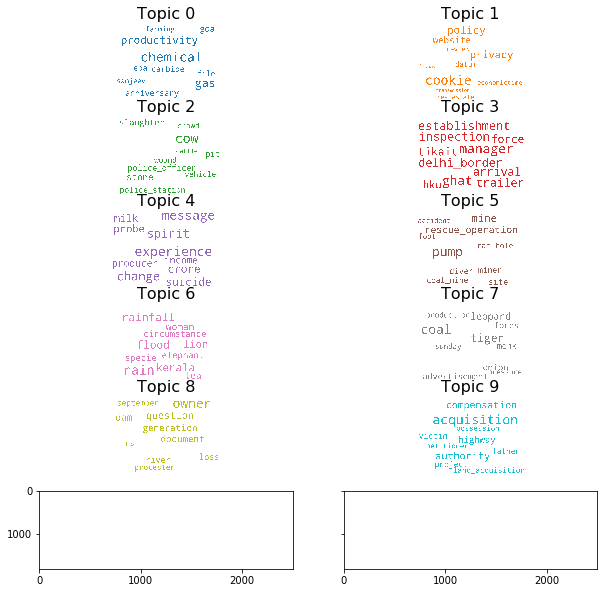

In [33]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words_nltk,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_dict['all_models'][topic_to_show].show_topics(formatted=False)

# Have to change this parameter
fig, axes = plt.subplots(6, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

In [ ]:
# When it comes to the keywords in the topics, the importance (weights) of 
# the keywords matters. Along with that, how frequently the words have appeared in the 
# documents is also interesting to look.

# Let’s plot the word counts and the weights of each keyword in the same chart.

# You want to keep an eye out on the words that occur in multiple topics and the 
# ones whose relative frequency is more than the weight. Often such words turn out to be 
# less important. The chart I’ve drawn below is a result of adding several such words to the 
# stop words list in the beginning and re-running the training process.

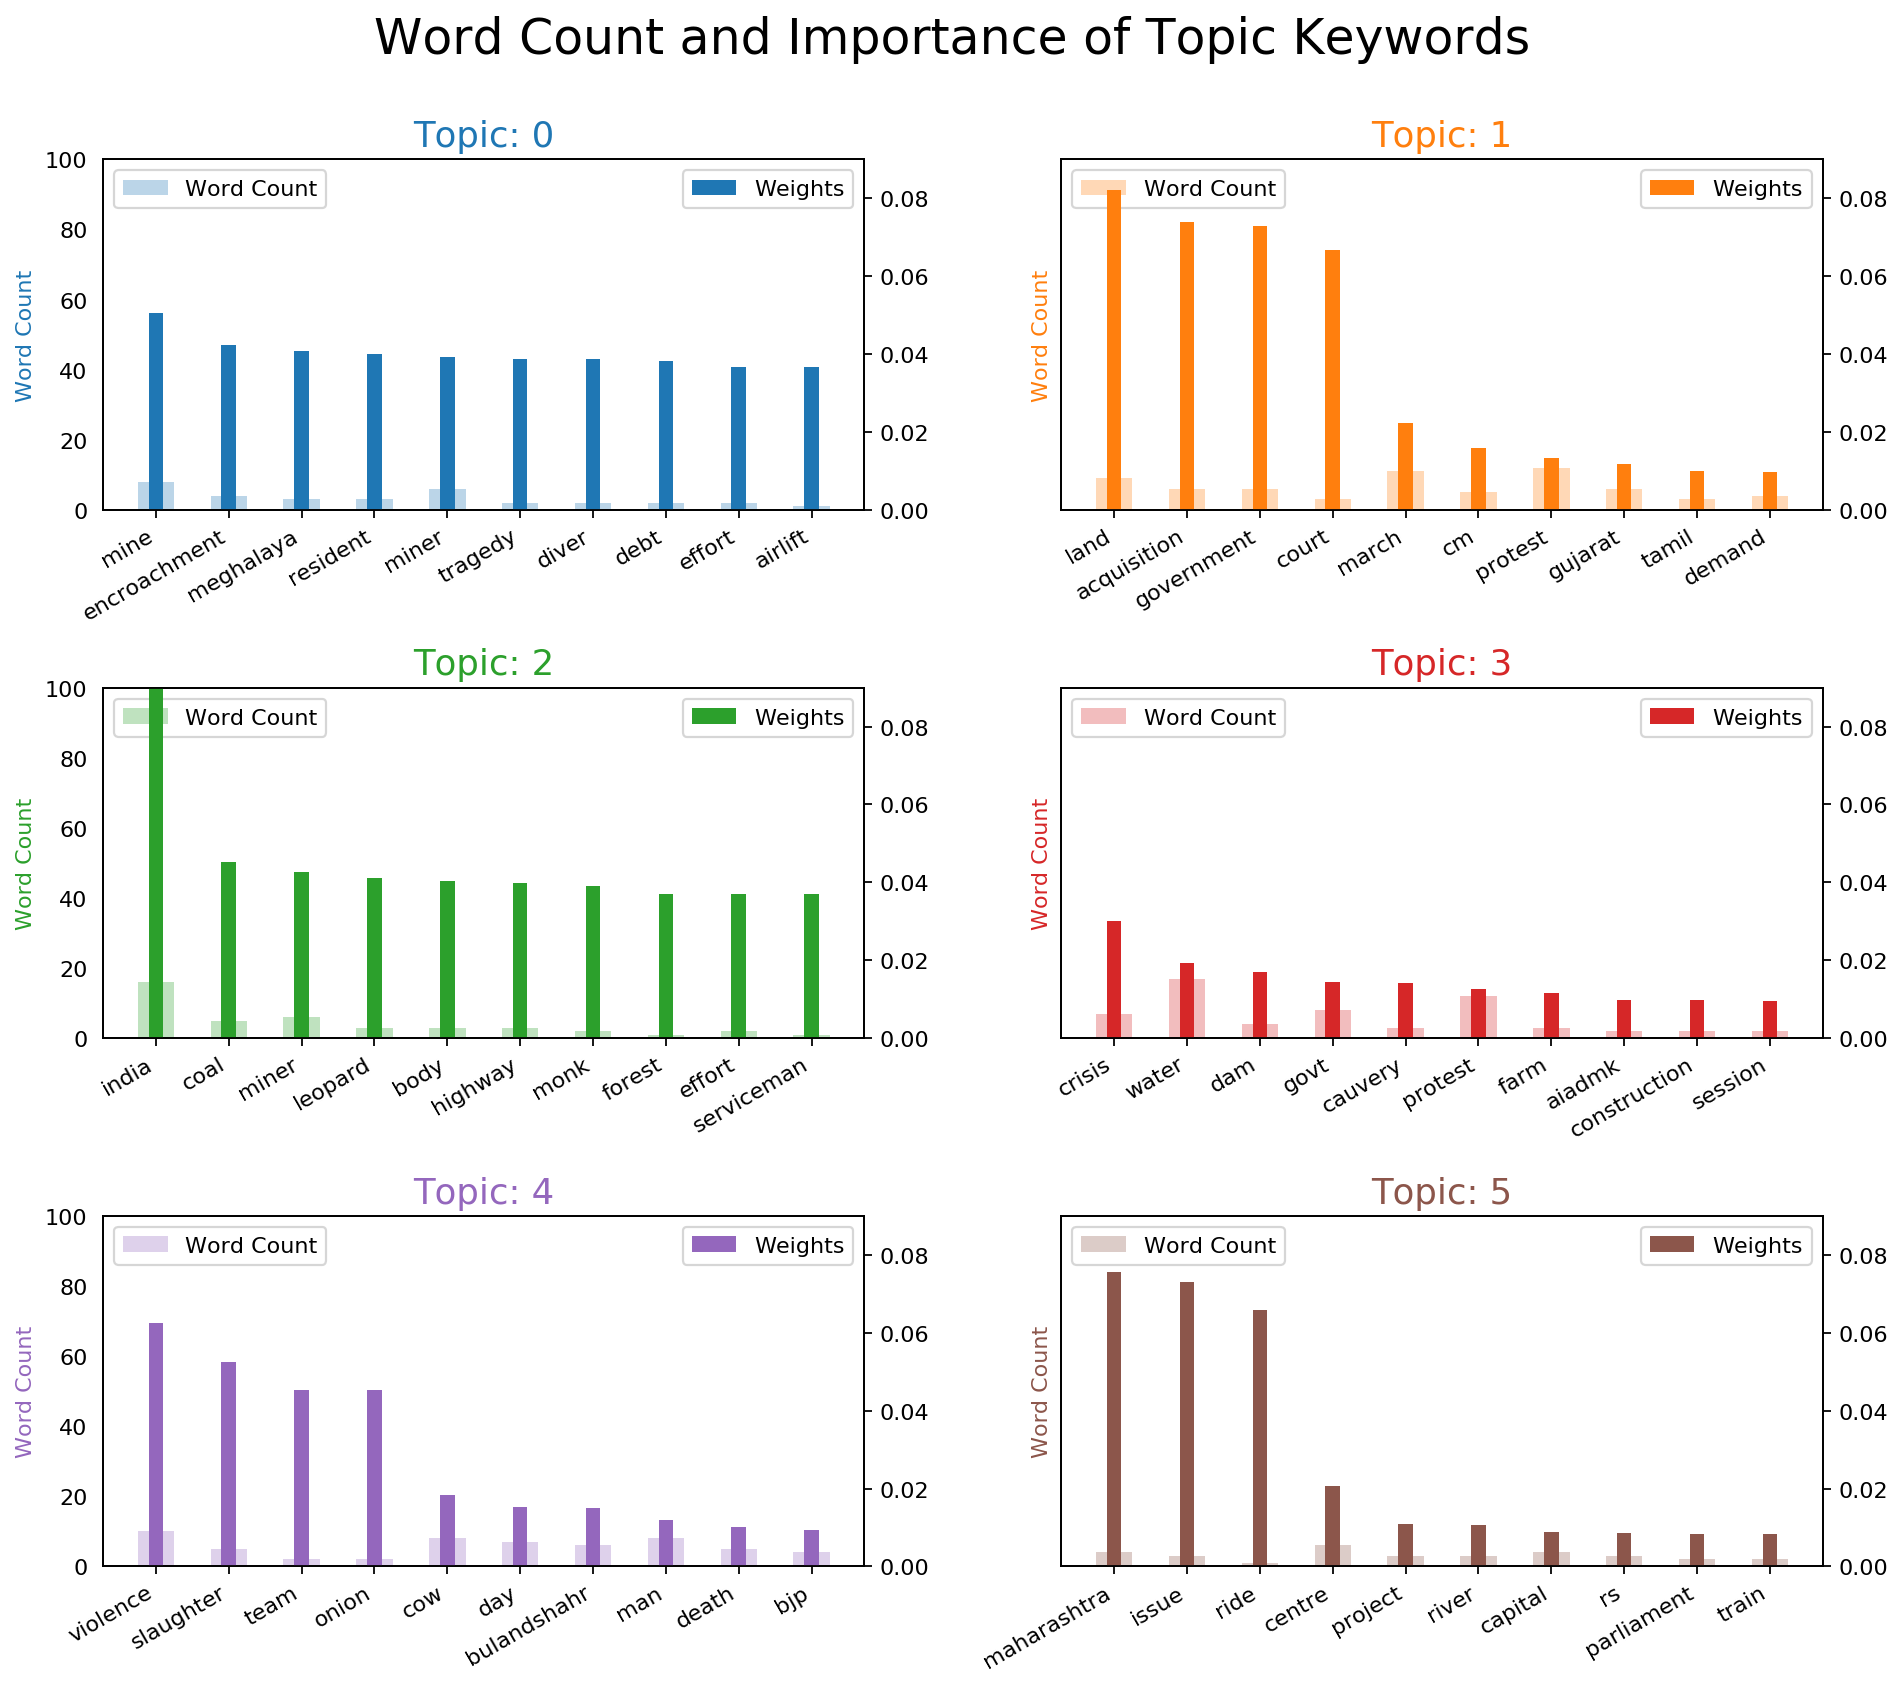

In [73]:
from collections import Counter
topics = lda_dict['all_models'][topic_to_show].show_topics(formatted=False)
data_flat = [w for w_list in doc_list for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.090); ax.set_ylim(0, 100)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

In [74]:
# Each word in the document is representative of one of the n topics. Let’s color 
# each word in the given documents by the topic id it is attributed to.
# The color of the enclosing rectangle is the topic assigned to the document.

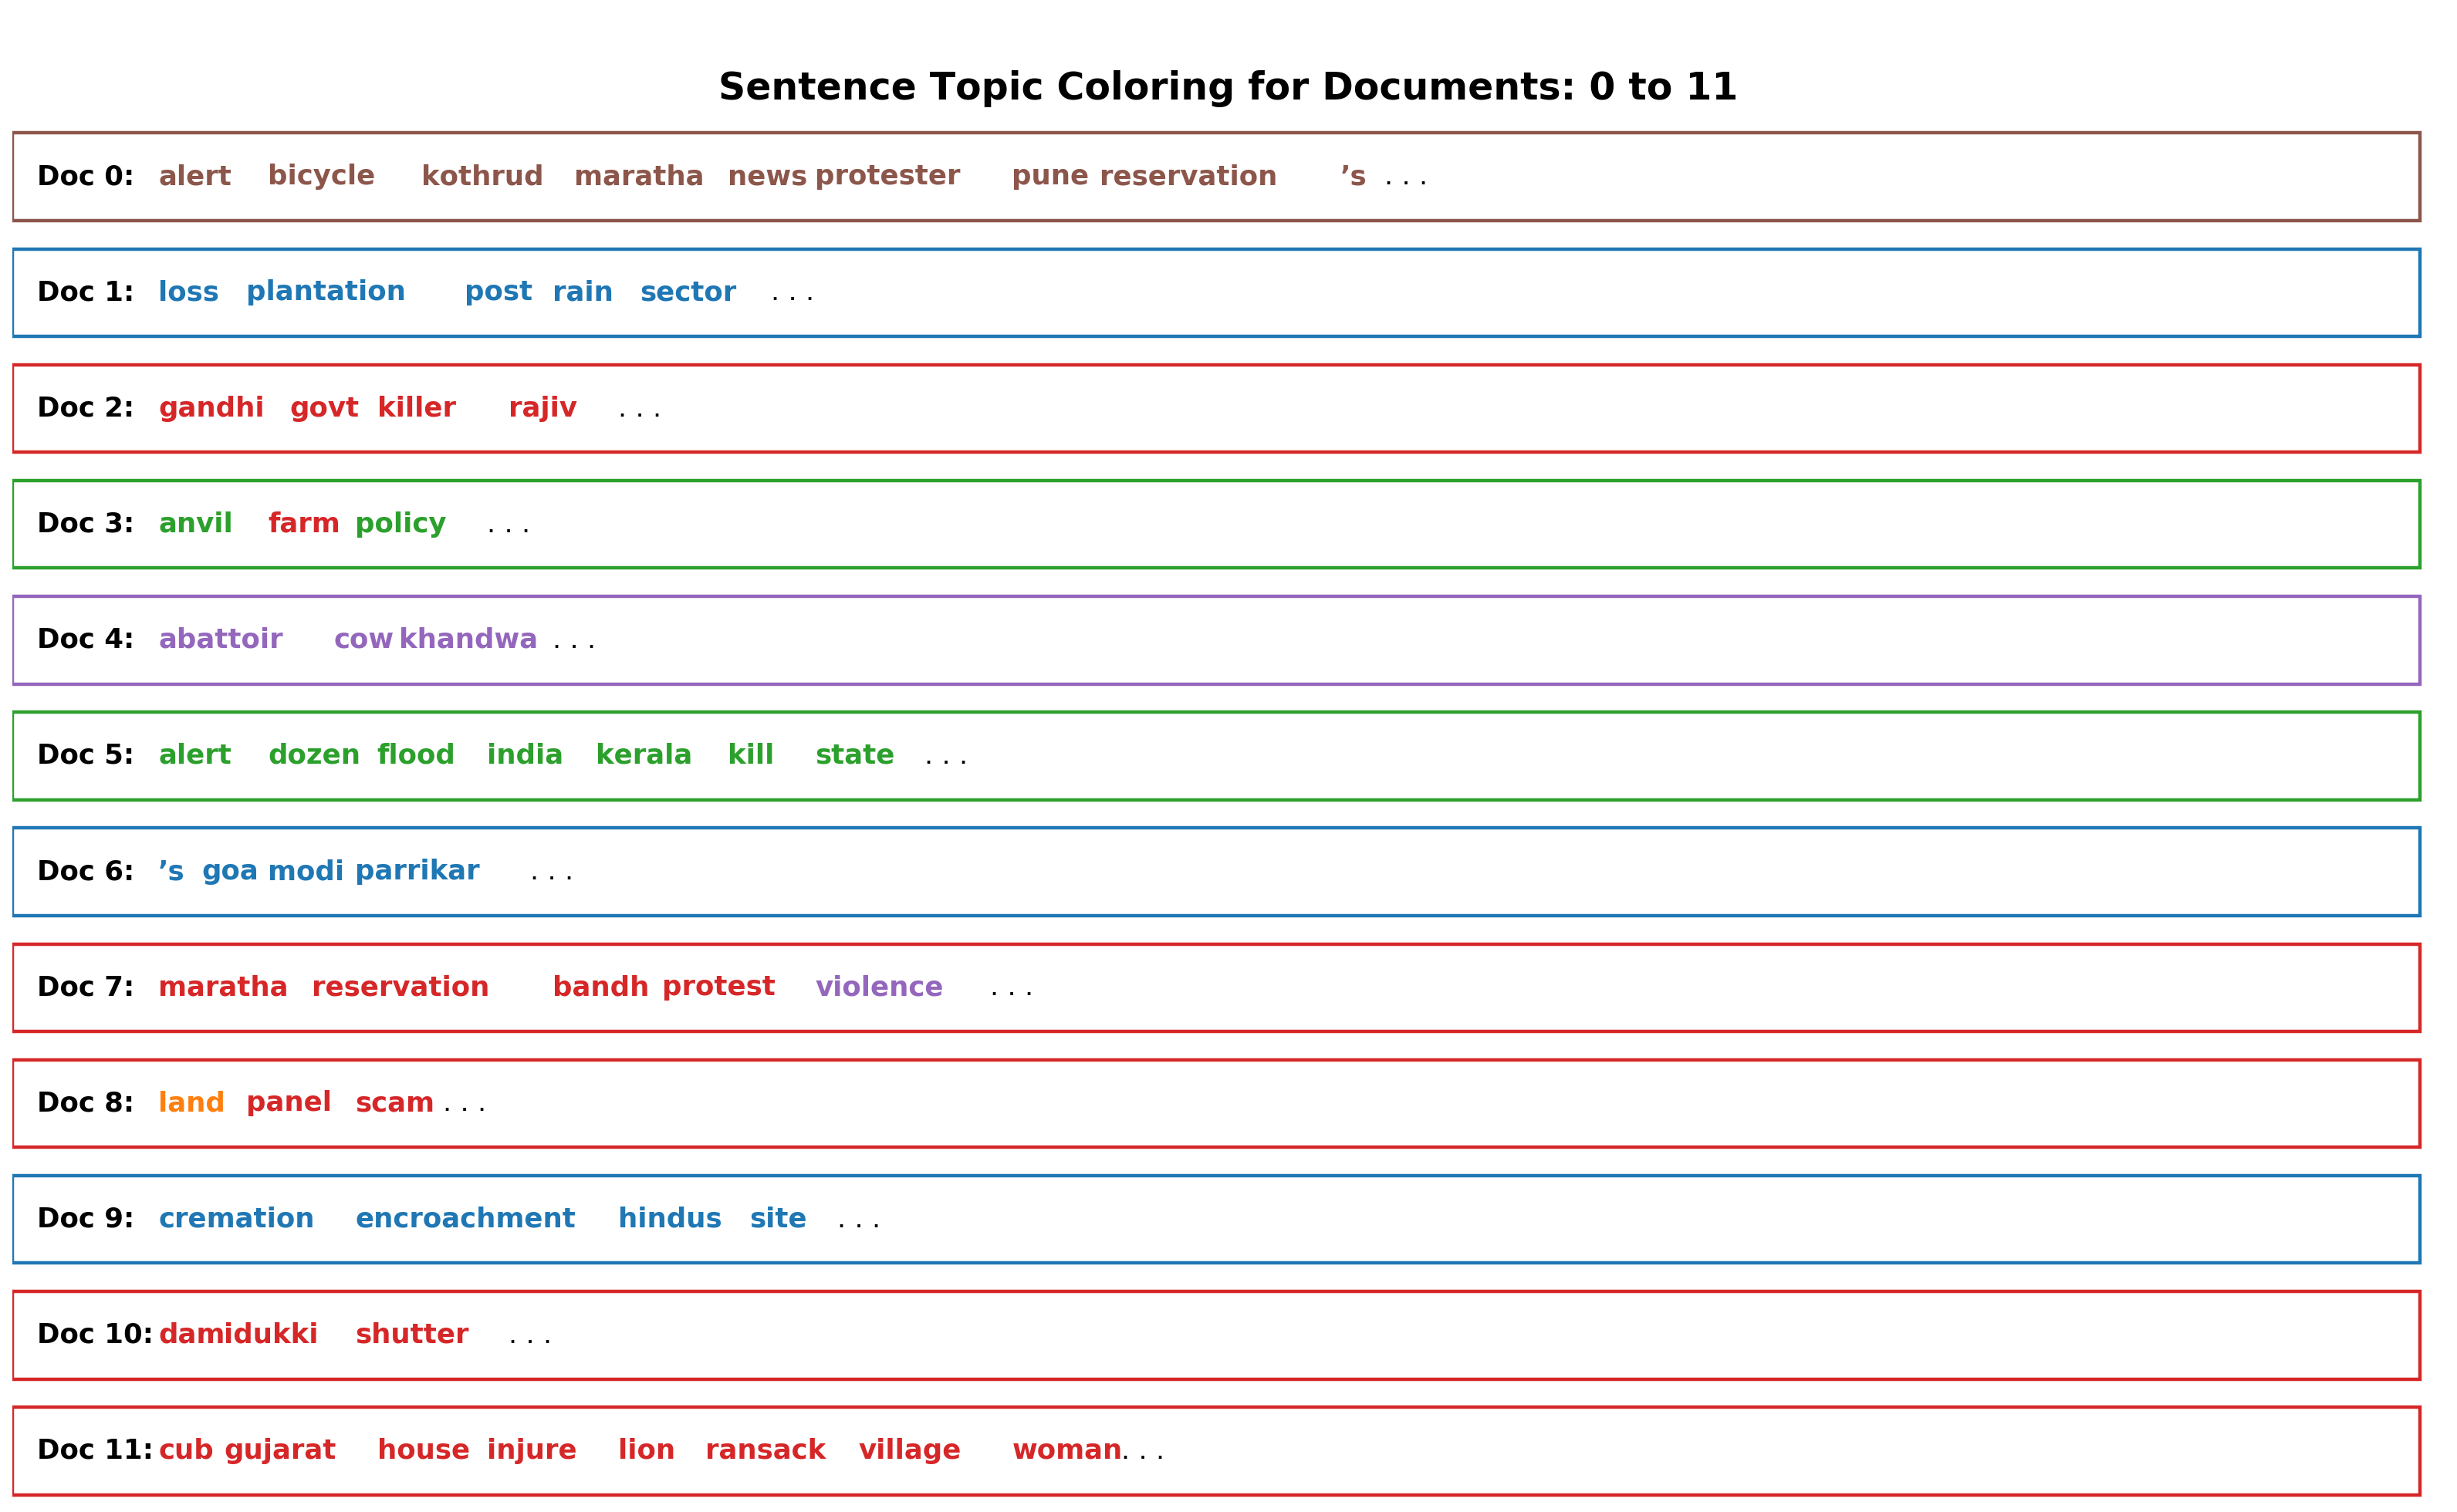

In [76]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_dict['all_models'][topic_to_show], corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

### What are the most discussed topics in the documents

In [77]:
# Let’s compute the total number of documents attributed to each topic

ValueError: too many values to unpack (expected 2)

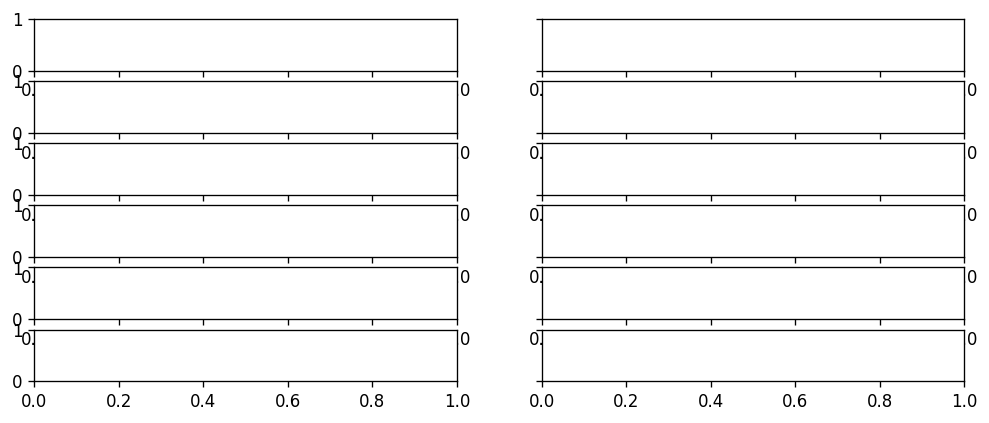

In [35]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_dict['all_models'][topic_to_show], corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_dict['all_models'][topic_to_show].show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Let’s make two plots:

# The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
# The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(6, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 100)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart

In [82]:
# Let’s visualize the clusters of documents in a 2D space 
# using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [36]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_dict['all_models'][topic_to_show][corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 204 samples in 0.000s...
[t-SNE] Computed neighbors for 204 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 204 / 204
[t-SNE] Mean sigma: 0.209894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.394569
[t-SNE] KL divergence after 900 iterations: 0.240870


Loading BokehJS ...